# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/home/ahmad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    #for row in open(file_name, encoding='utf8'):
    for row in open(file_name):
        if cnt < num_samples :
            #print(row)
            sents = row.split("\t")
            input_text = sents[0]
            
            target_text = '\t' + sents[1] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[1])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        #for row in open(file_name, encoding='utf8'):
        for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1
    # Add special tokens to vocab_to_int
    codes = ['\t','\n']
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1
    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t, vocab_to_int[char]] = 1.
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, vocab_to_int[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, vocab_to_int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [12]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    # TODO: Add Embedding for chars
    #encoder = LSTM(latent_dim, return_state=True) #LSTM
    encoder = Bidirectional(LSTM(latent_dim, return_state=True)) # Bi LSTM
    #encoder = Bidirectional(GRU(latent_dim, return_state=True))# Bi GRU
    #encoder = GRU(latent_dim, return_state=True)# GRU

    #encoder_outputs, state_h, state_c = encoder(encoder_inputs)# LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs)# Bi LSTM
    #encoder_outputs, state_f, state_b = encoder(encoder_inputs)# Bi GRU

    #state = Concatenate()([state_f, state_b])# Bi GRU
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    #encoder_states = [state]# Bi GRU
    #encoder_states = [state_f_h, state_f_c, state_b_h, state_b_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    #decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)# LSTM
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    #decoder_lstm = GRU(latent_dim*2, return_sequences=True, return_state=True)# Bi GRU
    '''
    decoder_outputs, _, _ = Bidirectional(decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states))
    '''

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)


    #decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    encoder_model = Model(encoder_inputs, encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    #decoder_states = [state] # Bi GRU
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Load data

In [13]:
data_path = '../../dat/'

In [14]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [15]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [16]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [17]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

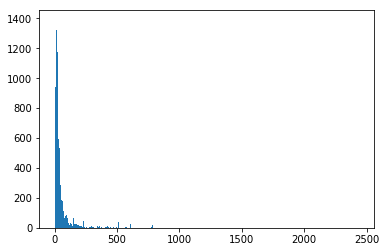

In [18]:
h = plt.hist(lengths, bins=500)

In [19]:
h[0]

array([1180.,  940., 1384., 1322., 1174.,  722.,  592.,  536.,  332.,
        286.,  242.,  186.,  180.,  214.,  112.,  154.,   68.,   82.,
         58.,   88.,   70.,   64.,   32.,   30.,   20.,   26.,   32.,
         24.,   58.,   14.,   64.,    6.,   28.,   16.,   24.,   28.,
          8.,   18.,   14.,   18.,   12.,   24.,   14.,   28.,   14.,
          4.,   12.,   44.,    4.,    6.,    2.,    4.,    6.,    0.,
         36.,    0.,    4.,    4.,    8.,    6.,   14.,    8.,    8.,
          8.,    2.,    0.,    6.,    2.,    2.,    4.,   12.,   14.,
          8.,   12.,    6.,    0.,    4.,    4.,    2.,    0.,    2.,
          0.,    4.,    6.,    0.,    4.,   14.,   26.,    4.,    0.,
          2.,    4.,    4.,    2.,    4.,    2.,    6.,    0.,    2.,
          2.,    2.,    6.,    4.,    2.,   40.,    4.,    0.,    0.,
          2.,    0.,    0.,    0.,    0.,    0.,    0.,   20.,    8.,
         18.,    4.,    0.,    0.,    0.,    0.,    6.,   24.,    2.,
          0.,    0.,

In [20]:
h[1]

array([   0.   ,    4.878,    9.756,   14.634,   19.512,   24.39 ,
         29.268,   34.146,   39.024,   43.902,   48.78 ,   53.658,
         58.536,   63.414,   68.292,   73.17 ,   78.048,   82.926,
         87.804,   92.682,   97.56 ,  102.438,  107.316,  112.194,
        117.072,  121.95 ,  126.828,  131.706,  136.584,  141.462,
        146.34 ,  151.218,  156.096,  160.974,  165.852,  170.73 ,
        175.608,  180.486,  185.364,  190.242,  195.12 ,  199.998,
        204.876,  209.754,  214.632,  219.51 ,  224.388,  229.266,
        234.144,  239.022,  243.9  ,  248.778,  253.656,  258.534,
        263.412,  268.29 ,  273.168,  278.046,  282.924,  287.802,
        292.68 ,  297.558,  302.436,  307.314,  312.192,  317.07 ,
        321.948,  326.826,  331.704,  336.582,  341.46 ,  346.338,
        351.216,  356.094,  360.972,  365.85 ,  370.728,  375.606,
        380.484,  385.362,  390.24 ,  395.118,  399.996,  404.874,
        409.752,  414.63 ,  419.508,  424.386,  429.264,  434.

In [21]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [22]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [23]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [24]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [25]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [26]:
len(input_texts)

3579

# Results of pre-training on generic data

In [27]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [28]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [29]:
num_samples = 1000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [30]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [31]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [32]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [33]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [34]:
# TODO

In [35]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

4579
lCi mye: VB Acdent - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


Policyolder/Ownker Inyformatin 
 	Policyholder/Owner Information


Firs Name: 
 	First Name:


Middle NameI/nitial: 
 	Middle Name/Initial:


Las tName: 
 	Last Name:


oScial Security Numbr
 
 	Social Security Number:


Birth te: 
 	Birth Date:


Gender: 
 	Gender:


aLnguage Preferecne: 
 	Language Preference:


Address Line 1: 
 	Address Line 1:




## Build vocab

In [36]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [37]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [38]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 4579
Number of unique input tokens: 114
Number of unique output tokens: 114
Max sequence length for inputs: 49
Max sequence length for outputs: 49


# Prepare training data

## Train/test split

In [39]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [40]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Test data

In [41]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [42]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [43]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 114)    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 759808      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 114)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3

# Training

In [44]:
batch_size = 64  # Batch size for training.
epochs = 50  
lr = 0.01

# Learning rate decay

In [45]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [47]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [48]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [49]:
#callbacks_list.append(lrate)

In [50]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 3892 samples, validate on 687 samples
Epoch 1/50
3892/3892 [==============================] - 87s 22ms/step - loss: 1.6350 - categorical_accuracy: 0.0746 - val_loss: 1.3185 - val_categorical_accuracy: 0.1233

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12325, saving model to best_model.hdf5


/home/ahmad/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
3892/3892 [==============================] - 82s 21ms/step - loss: 1.0921 - categorical_accuracy: 0.1688 - val_loss: 0.9334 - val_categorical_accuracy: 0.2162

Epoch 00002: val_categorical_accuracy improved from 0.12325 to 0.21620, saving model to best_model.hdf5
Epoch 3/50
3892/3892 [==============================] - 100s 26ms/step - loss: 0.7969 - categorical_accuracy: 0.2517 - val_loss: 0.7260 - val_categorical_accuracy: 0.2779

Epoch 00003: val_categorical_accuracy improved from 0.21620 to 0.27787, saving model to best_model.hdf5
Epoch 4/50
3892/3892 [==============================] - 97s 25ms/step - loss: 0.6008 - categorical_accuracy: 0.3072 - val_loss: 0.5793 - val_categorical_accuracy: 0.3178

Epoch 00004: val_categorical_accuracy improved from 0.27787 to 0.31783, saving model to best_model.hdf5
Epoch 5/50
3892/3892 [==============================] - 93s 24ms/step - loss: 0.4617 - categorical_accuracy: 0.3463 - val_loss: 0.4937 - val_categorical_accuracy: 0.3449

Epo

3892/3892 [==============================] - 88s 23ms/step - loss: 0.0894 - categorical_accuracy: 0.4409 - val_loss: 0.3784 - val_categorical_accuracy: 0.3915

Epoch 00033: val_categorical_accuracy did not improve from 0.40127
Epoch 34/50
3892/3892 [==============================] - 87s 22ms/step - loss: 0.0813 - categorical_accuracy: 0.4430 - val_loss: 0.3796 - val_categorical_accuracy: 0.3948

Epoch 00034: val_categorical_accuracy did not improve from 0.40127
Epoch 35/50
3892/3892 [==============================] - 84s 22ms/step - loss: 0.0696 - categorical_accuracy: 0.4471 - val_loss: 0.3824 - val_categorical_accuracy: 0.3952

Epoch 00035: val_categorical_accuracy did not improve from 0.40127
Epoch 36/50
3892/3892 [==============================] - 84s 22ms/step - loss: 0.0733 - categorical_accuracy: 0.4457 - val_loss: 0.3942 - val_categorical_accuracy: 0.3908

Epoch 00036: val_categorical_accuracy did not improve from 0.40127
Epoch 37/50
3892/3892 [==============================] -

In [51]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

/home/ahmad/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [52]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: eDdcutible
GT sentence: Deductible

Decoded sentence: Deductible

-
Input sentence: 07’132
GT sentence: 07/32

Decoded sentence: 07/32

-
Input sentence: Patient Health Questionnaire [PHQ—Z) 0
GT sentence: Patient Health Questionnaire (PHQ-2)

Decoded sentence: Patient Health Que: 37-m (andional Injury

-
Input sentence: Current Medications:
GT sentence: Current Medications:

Decoded sentence: Current Fervice Fers:

-
Input sentence: Electromcally Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: Business Telephone:
GT sentence: Business Telephone:

Decoded sentence: Business Telephone:

-
Input sentence: Gender
GT sentence: Gender:

Decoded sentence: Gender:

-
Input sentence: BALANCE DUE
GT sentence: BALANCE DUE

Decoded sentence: BALANE DUE

-
Input sentence: unum‘t 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: Employee Wellness BenefitJ anuar y1, 2017
G

-
Input sentence: Tota lEmployee Semi-Monthly Payrollv Deduction:
GT sentence: Total Employee Semi-Monthly Payroll Deduction:

Decoded sentence: Total Employee Semi-Monthance Patie Palmity $

-
Input sentence: Dependent Information
GT sentence: Dependent Information

Decoded sentence: Dependent Information

-
Input sentence: LGarrier
GT sentence: Other Carrier Paid

Decoded sentence: Other Carried

-
Input sentence: Claim Type: VB Accident - Accidental Injury
GT sentence: Claim Type: VB Accident - Accidental Injury

Decoded sentence: Claim Type: VB Accident - Accidental Injury

-
Input sentence: Aullwowed Amountv
GT sentence: Allowed Amount

Decoded sentence: Allowed Amount

-
Input sentence: Screening Tools
GT sentence: Screening Tools

Decoded sentence: Screnced Oncbulid

-
Input sentence: DATES] OF SERVICE
GT sentence: DATE(S) OF SERVICE

Decoded sentence: DATE(S) OF SOw FORM

-
Input sentence: ORTHOPEDICS
GT sentence: ORTHOPEDICS

Decoded sentence: ORTHOPEDICS

-
Input sentence: PA

In [53]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [54]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: EMPLOYEE LAST NAME:
GT sentence: EMPLOYEE LAST NAME:

Decoded sentence: EMPLOYE STATTIENT

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: To whom this may concern:
GT sentence: To whom this may concern:

Decoded sentence: Tothe Emaim of by be Rights

-
Input sentence: (Name) ._ (Telephone Number)
GT sentence: (Name)  (Telephone Number)

Decoded sentence: (Name) (T77.20 mg/% (9/2)

-
Input sentence: Employee On ER Off-Job Acc February 1, 2016
GT sentence: Employee On & Off-Job Acc February 1, 2016

Decoded sentence: Employee Of 2V Vity 2V Valley COM F77999X-18

-
Input sentence: Provider
GT sentence: Provider

Decoded sentence: Provider:

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES :
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: EMERGENSYe: ADD EXAMINITS

-
Input sentence: 43cF.
GT sentence: 43F.

Decoded sentence: AR:

-
Input sentence: • HR 83 (/mxin)
GT sentence: • HR 83 (/min)

Decoded sentenc

-
Input sentence: Total oPatient Rseponsibilit

GT sentence: Total Patient Responsibility

Decoded sentence: Total Patient Responsibility

-
Input sentence: Charge
GT sentence: Charge

Decoded sentence: Chercer

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Gender:

-
Input sentence: Website: myFirstChoioetohh com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: Website: myFirstChoice.fchn.com

-
Input sentence: Social Security Number:
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: Bsunes eTlephone: 
GT sentence: Business Telephone: 

Decoded sentence: Busines  the: nele:

-
Input sentence: M 'calSecialty 5: f: . Leg“? '
GT sentence: Medical Specialty Degree

Decoded sentence: Medical Seciusenc Notes:

-
Input sentence: Ad ust
GT sentence: Adjust.

Decoded sentence: Adduct

-
Input sentence: Final Details: EE do

-
Input sentence: Custom Question 1 —
GT sentence: Custom Question 1 -

Decoded sentence: Customes  of Conter

-
Input sentence: Cardiovascular: Negative for chest pain.
GT sentence: Cardiovascular: Negative for chest pain.

Decoded sentence: Cardical armation absen or tersprecorderg

-
Input sentence: Claim Bent Information
GT sentence: Claim Event Information

Decoded sentence: Claim Event Information

-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Effective To Date:
GT sentence: Effective To Date:

Decoded sentence: Effective Type: DuTr

-
Input sentence: Language Prefeekrenc:
GT sentence: Language Preference:

Decoded sentence: Language Preference:

-
Input sentence: Full Day Worked?
GT sentence: Full Day Worked? Yes

Decoded sentence: Fungay To Kny -

-
Input sentence: Employee 0n 3L Off-Job Acc September 1, 2017
GT sentence: Employee On & Off-Job Acc September 1, 2017

Decoded sentence: Employee On & Off-Job Acc September 1, 2017



-
Input sentence: if yes, please provide the toitowing:
GT sentence: If yes, please provide the following:

Decoded sentence: If yes, ase writtaule homportting age: (mm/dd/yy)

-
Input sentence: The Beneffits Center
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: MEDICAL CENTE
GT sentence: MEDICAL CENTER

Decoded sentence: MEICEDT OF HOPEDICS

-
Input sentence: Printed by
GT sentence: Printed by

Decoded sentence: Printed by:

-
Input sentence: Page 2
GT sentence: Page 2

Decoded sentence: Page 2

-
Input sentence: Family History:
GT sentence: Family History:

Decoded sentence: Family History:

-
Input sentence: Policg'h old er: Owner Information
GT sentence: Policyholder/Owner Information

Decoded sentence: Policyholder: Owner Information

-
Input sentence: Flea;
GT sentence: Filed:

Decoded sentence: PleN

-
Input sentence: Pain Medicine: Please take as needed.
GT sentence: Pain Medicine: Please take as needed.

Decoded sentence: Pained Medi

-
Input sentence: ARMC-Athens Regional Medical Center
GT sentence: ARMC-Athens Regional Medical Center

Decoded sentence: ARMC-Athens Regional Medical Center

-
Input sentence: Community Health Centers
GT sentence: Community Health Centers

Decoded sentence: Compumtemsmint Idment Indaction

-
Input sentence: Customer #:
GT sentence: Customer #:

Decoded sentence: Custimer ID#:

-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Custimer Polmaly: PI-CAENT

-
Input sentence: www.rays.net
GT sentence: www.rays.net

Decoded sentence: www. yerred.

-
Input sentence: Claim Details
GT sentence: Claim Details

Decoded sentence: Claim Details

-
Input sentence: DIGIT 5??UL
GT sentence: 5-DIGIT 57701

Decoded sentence: DIGG PHYS

-
Input sentence: Electroniclaly Signed Dpatie:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Insured

-
Input sentence: Electronically S igncd Date:
GT sentence: Electronically Signed Date:

Decod

-
Input sentence: Social Secuiruty Nuber:
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: •b Letharg and coh
GT sentence: • Lethargy and cough

Decoded sentence: • Lumbra, Stress

-
Input sentence: Ciy: 
GT sentence: City: 

Decoded sentence: City:

-
Input sentence: PROCEDURE NOJREVENUE CODE
GT sentence: PROCEDURE NO./REVENUE CODE

Decoded sentence: PROCEDURE NO0320 Varil 1, 2016

-
Input sentence: Participnat Naem:
GT sentence: Participant Name:

Decoded sentence: Participant Name:

-
Input sentence: PATIENT‘S NAME
GT sentence: PATIENT'S NAME

Decoded sentence: PTANANT AND 

-
Input sentence: Medical Provide rImnforamton - Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information - Physician

-
Input sentence: Social 8 ecurity Number:
GT sentence: Social Security Number:

Decoded sentence: Soctal Security Number:

-
Input sentence: Address
GT sentence: Address

Decoded sentence: A

-
Input sentence: Postal Codes 4 92 02
GT sentence: Postal Codes: 49202

Decoded sentence: Postal Code: 202/2X/2018

-
Input sentence: Expected Delivery Date; (mmfddlvy)
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: Expected Delivery Date (mm/dd/yy):

-
Input sentence: Cardlovascular: no cardiovascular symptoms.
GT sentence: Cardiovascular: no cardiovascular symptoms.

Decoded sentence: Cardicallarmedical Hospriater surgery a.medarte

-
Input sentence: Trace number:
GT sentence: Trace number:

Decoded sentence: Trace chented:

-
Input sentence: Poilcy Number:
GT sentence: Policy Number:

Decoded sentence: Policy Number:

-
Input sentence: The Beeafis Cente
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: E DEDUCTiBLE OUT OF POCKET
GT sentence: DEDUCTIBLE OUT OF POCKET

Decoded sentence: ED CTTE OF TOMABETHO-ERD

-
Input sentence: Medical Provider Specialty. Other
GT sentence: Medical Provider Specialty: Other

Decoded sente

-
Input sentence: • HGB - 14c.0 Range: 11.51-5. 5k- gd/L
GT sentence: • HGB - 14.0 Range: 11.5-15.5 - g/dL

Decoded sentence: • HOT D a day 1, 20173 - mg/dL

-
Input sentence: Cliam Eent Idetifier:
GT sentence: Claim Event Identifier:

Decoded sentence: Claim Event Identifier:

-
Input sentence: All Other Lanugages Contact
GT sentence: All Other Languages Contact

Decoded sentence: All Other Languages Contact

-
Input sentence: STA'EMENT
GT sentence: STATEMENT

Decoded sentence: STATEMENT

-
Input sentence: Knee Exam
GT sentence: Knee Exam

Decoded sentence: Knee Exem

-
Input sentence: Business Fax
GT sentence: Business Fax:

Decoded sentence: Business Fill

-
Input sentence: It yes, please provide the following:
GT sentence: If yes, please provide the following:

Decoded sentence: If yes, preate sull weal cllling th

-
Input sentence: U n U m‘
GT sentence: unum

Decoded sentence: unum

-
Input sentence: 2“CI Surgery] Procedure: Date:
GT sentence: 2nd Surgery/Procedure: Date:

Decoded

-
Input sentence: Conﬁrmation of Coverage
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage

-
Input sentence: Eyes: Conjunctivae and EOM are normal.
GT sentence: Eyes: Conjunctivae and EOM are normal.

Decoded sentence: EXIZ: Nonr apprain, Nreet dirithang

-
Input sentence: Date ofDischarge:
GT sentence: Date of Discharge:

Decoded sentence: Date of Discharge:

-
Input sentence: Patient Name:
GT sentence: Patient Name:

Decoded sentence: Patient Name:

-
Input sentence: Account:
GT sentence: Account:

Decoded sentence: Account #:

-
Input sentence: Diganosis
GT sentence: Diagnosis

Decoded sentence: Diagnosis:

-
Input sentence: PROCEDURE MODEFIER
GT sentence: PROCEDURE MODIFIER

Decoded sentence: PROCEDURE RO0 No

-
Input sentence: Date éigneé
GT sentence: Date Signed

Decoded sentence: Date Signed

-
Input sentence: kCouuntry:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: nIsurde’s Siganture Date Signed
GT sentence: Insured’s Si

-
Input sentence: l:lState Disability Benefits
GT sentence: State Disability Benefits

Decoded sentence: Stite Vitals Tied Details

-
Input sentence: Employee:
GT sentence: Employee:

Decoded sentence: Employee:

-
Input sentence: Date of Birth (mmidww)_
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mm/dd/yy)

-
Input sentence: C16 TX Phaiangealfx Prox/mid; H/man
GT sentence: Clo Tx Phalangealfx Prox/mid; W/man

Decoded sentence: CLace Patient Pain: Premarming

-
Input sentence: City:h 
GT sentence: City: 

Decoded sentence: City:

-
Input sentence: 1 23 99284
GT sentence: 1 23 99284 EMERGENCY DEPT VISIT

Decoded sentence: 199242

-
Input sentence: ' Participant ID:
GT sentence: Participant ID:

Decoded sentence: Participant ID:

-
Input sentence: First Choice Health
GT sentence: First Choice Health

Decoded sentence: First Choice Health

-
Input sentence: Provider: Dan Paler
GT sentence: Provider: Dan Palmer

Decoded sentence: Provider: Dan Palmer

-
Input se

In [55]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.09551451187335093


In [56]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.08397097625329815


# Test on separate tesseract corrected file

In [57]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

-
Input sentence: Me dieal Provider Roles: Treating 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Provider First Name: Christine 
GT sentence: Provider First Name: Christine

Decoded sentence: Provider First Name: Reherdact

-
Input sentence: Provider Last Name: Nolen, MD 
GT sentence: Provider Last Name: Nolen, MD

Decoded sentence: Provider Last Name: Nolenas:

-
Input sentence: Address Line 1 : 7 25 American Avenue 
GT sentence: Address Line 1 : 725 American Avenue

Decoded sentence: Address Line 1 : 140 - 104 405 - X-50

-
Input sentence: City. W’aukesha 
GT sentence: City: Waukesha

Decoded sentence: City To the bium

-
Input sentence: StatefProvinee: ‘WI 
GT sentence: State/Province: WI

Decoded sentence: State/Province Plon:

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Postal Code: 202reman

-
Input sentence: Country". US 
GT sentence: Country:  US

Decoded sent

-
Input sentence: IOVER 120 DAYS 
GT sentence: OVER 120 DAYS

Decoded sentence: OVERS’ DOOUS

-
Input sentence: ILAST PAY DATEI 
GT sentence: LAST PAY DATE

Decoded sentence: LAST PATS UNT 

-
Input sentence: STMT DATE 
GT sentence: STMT DATE 

Decoded sentence: STMT DATE

-
Input sentence: BALANCE DUE 
GT sentence: BALANCE DUE

Decoded sentence: BALANE DUE

-
Input sentence: DOCTOR LEGEND 
GT sentence: DOCTOR LEGEND

Decoded sentence: DOCTION OF 2 o

-
Input sentence: 1 NOLEN, CHRISTINE, M. D. 
GT sentence: 1 NOLEN, CHRISTINE, M. D.

Decoded sentence: 1 NOLENS: REFTHESSOMD

-
Input sentence: COMMENTS 
GT sentence: COMMENTS

Decoded sentence: COMMENTS

-
Input sentence: PRIMARY INSUR: UMR FISERV WI 
GT sentence: PRIMARY INSUR: UMR FISERV WI

Decoded sentence: PRIMARY INSUR: UMR FIR WITH:

-
Input sentence: SECONDARY INSUR: 
GT sentence: SECONDARY INSUR:

Decoded sentence: SER OF YORY OF SORA

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Dec

-
Input sentence: 0 : 10 years 
GT sentence: • : 10 years

Decoded sentence: • : 10 year Admiss.

-
Input sentence: Current Made 
GT sentence: Current Made

Decoded sentence: Current Medicatur

-
Input sentence: 3. Multi-Vitamin TABS; 
GT sentence: 3. Multi-Vitamin TABS;

Decoded sentence: 3. Tull TiV Type Conrilt

-
Input sentence: Therapy: (Recordedz24Jan2018) to Recorded 
GT sentence: Therapy: (Recorded:24Jan2018) to Recorded

Decoded sentence: Thecary: 2 - Raken - Accidentar Apjustment

-
Input sentence: 4. Probiotic CAPS; 
GT sentence: 4. Probiotic CAPS;

Decoded sentence: 4. Probiotional Hi-2

-
Input sentence: Therapy: 21Jan2018 to Recorded 
GT sentence: Therapy: 21Jan2018 to Recorded

Decoded sentence: Theaded: 24Jan201891 MRI, LWR 

-
Input sentence: -- McMurray’s 
GT sentence: -- McMurray’s

Decoded sentence: Camee Meusent

-
Input sentence: symmetric dial at 0 and 90 degrees 
GT sentence: symmetric dial at 0 and 90 degrees

Decoded sentence: symmetric ditledatt date enam of 

-
Input sentence: HematologiciLymphatic no hematologic symptoms. 
GT sentence: Hematologic/Lymphatic no hematologic symptoms.

Decoded sentence: Hom. Totholicatic th stopic atrtomitationalution

-
Input sentence: Neurological: no neurological symptoms. 
GT sentence: Neurological: no neurological symptoms.

Decoded sentence: Neurological: ne normalm. Notes worronal

-
Input sentence: Psychiatric: no psychiatric symptoms. 
GT sentence: Psychiatric: no psychiatric symptoms.

Decoded sentence: Psycitich Homriotacrional History: No.

-
Input sentence: Respiratory: no respiratory symptoms. 
GT sentence: Respiratory: no respiratory symptoms.

Decoded sentence: Respiriturr of Health Instruption abment

-
Input sentence: Active Problems 
GT sentence: Active Problems

Decoded sentence: Active Problems

-
Input sentence: 1. Knee injury 
GT sentence: 1. Knee injury

Decoded sentence: 1. Knee injury

-
Input sentence: Past Medical History 
GT sentence: Past Medical History

Decoded sentence: Pastic

-
Input sentence: Diagnosis 
GT sentence: Diagnosis

Decoded sentence: Diagnosis:

-
Input sentence: Plan 
GT sentence: Plan

Decoded sentence: Plan 

-
Input sentence: DiscussionlSummary 
GT sentence: Discussion/Summary

Decoded sentence: Discussion/Summary

-
Input sentence: Signatures 
GT sentence: Signatures

Decoded sentence: Signature Date

-
Input sentence: Electronicaliy signed by : Jamie Birkelo, PA; 
GT sentence: Electronically signed by : Jamie Birkelo, PA;

Decoded sentence: Electronically signed by Sarnive Physician

-
Input sentence: altiltliigélés 
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: TWITling the

-
Input sentence: Plan 
GT sentence: Plan

Decoded sentence: Plan 

-
Input sentence: Knee injury 
GT sentence: Knee injury

Decoded sentence: Kneenive 2 * COM

-
Input sentence: Last Updated ByzKim, Daniel;Ordered; 
GT sentence: Last Updated By:Kim, Daniel;Ordered;

Decoded sentence: Lant Ded Biredut: Devinald, p. The

-
Input sentence: For:Knee injury; Ord

-
Input sentence: Acoldent / Injury — no 
GT sentence: Accident / Injury - no

Decoded sentence: Accodent Dotes (center

-
Input sentence: Is your accident/illness work related — yes 
GT sentence: Is your accident/illness work related - yes

Decoded sentence: Is your lack w/acture and live spanus fort

-
Input sentence: Claim filed — yes 
GT sentence: Claim filed - yes

Decoded sentence: Claim tived anters

-
Input sentence: Employee Health Medical Category [FML] — blood 
GT sentence: Employee Health Medical Category [FML] - blood

Decoded sentence: Employee Suttart Charger Fatmer Father Fatier)

-
Input sentence: Surgery — no 
GT sentence: Surgery - no

Decoded sentence: Surgery - no

-
Input sentence: Show work schedule - [] 
GT sentence: Show work schedule - []

Decoded sentence: Show work ferwory - 031

-
Input sentence: Average hours per week — 40 
GT sentence: Average hours per week - 40

Decoded sentence: Average hevere ant proness.

-
Input sentence: First treatment date 
GT se

-
Input sentence: Leave type — full 
GT sentence: Leave type - full

Decoded sentence: Leave ave limetsun

-
Input sentence: Last day worked 
GT sentence: Last day worked

Decoded sentence: Last name - yes

-
Input sentence: Resident State on LDW — NC 
GT sentence: Resident State on LDW - NC

Decoded sentence: Resined Status Date Specine

-
Input sentence: Full shift last day - no 
GT sentence: Full shift last day - no

Decoded sentence: Full hostite rtart formt

-
Input sentence: Absence start time  
GT sentence: Absence start time 

Decoded sentence: Absented me emegent

-
Input sentence: Absence end time  
GT sentence: Absence end time 

Decoded sentence: Absenced acher Des

-
Input sentence: Any overtime? - no 
GT sentence: Any overtime? - no

Decoded sentence: Any overtime? % - 3 2

-
Input sentence: Lunch break — 
GT sentence: Lunch break -

Decoded sentence: Lunch critted

-
Input sentence: Total time absent — 
GT sentence: Total time absent -

Decoded sentence: Total time ate v

-
Input sentence: Please check the type of claim you are filing:
GT sentence: Please check the type of claim you are filing:

Decoded sentence: Please check the typepote flections your at 309899
-
Input sentence: 8. information About the Inauroleollcyholdor
GT sentence: B. Information About the Insured/Policyholder

Decoded sentence: B. Iffice on wratten in availy Peration intart

-
Input sentence: Last Name Suffix First Name MI
GT sentence: Last Name Suffix First Name  MI

Decoded sentence: Last Name INF to Rt. Nondition

-
Input sentence: Language l-Ireloronce Ll hngllsh El Spanish
GT sentence: Language Preference English Spanish

Decoded sentence: Language Preference English Spenish

-
Input sentence: Last Name Suffix Flrst Name Ml
GT sentence: Last Name Suffix First Name MI

Decoded sentence: Last Name In/0umber Fions/at/F)

-
Input sentence: Date at Birth tmrnlddr’yy)
GT sentence: Date of Birth (mm/dd/yy) 

Decoded sentence: Date Bart Birth (mm/dd/yy)

-
Input sentence: Social Sec

-
Input sentence: lREFnarks Description 
GT sentence: Services Description

Decoded sentence: Serving Description

-
Input sentence: lREFnarks Description 
GT sentence: Remarks Description

Decoded sentence: Serving Description

-
Input sentence: 1 Processed at [he Tier 1 Contracted Rate 
GT sentence: 1 Processed at the Tier 1 Contracted Rate

Decoded sentence: 1/ureess all righe famtory an the medial

-
Input sentence: TERWamny nmctmle __""'"‘"‘”"“ " 
GT sentence: TIER 1 Family Deductible8

Decoded sentence: TIERT Family

-
Input sentence: TIER 1 Family MOOF’ 
GT sentence: TIER 1 Family MOOP Max

Decoded sentence: TIER 1 Family Deduction:

-
Input sentence: TIER 1 Individual Deductible 
GT sentence: TIER 1 Individual Deductible 

Decoded sentence: TIER 1 Individual Deductible

-
Input sentence: TIER 1 10011110001 MDOP Max 
GT sentence: TIER 1 Individual MOOP Max 

Decoded sentence: TIER 1 Individual MOOP Max Cole

-
Input sentence: TIER 2 Family  
GT sentence: TIER 2 Family Deductible

-
Input sentence: Covera ge In r WV r T W 
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insures Coverage Type Coverage Effective Date

-
Input sentence: Employee Off-Job Acc
GT sentence: Employee Off-Job Acc April

Decoded sentence: Employee Off-Job Acc April 1, 2017

-
Input sentence: mployee Sickness Hospital Confinement 
GT sentence: Employee Sickness Hospital Confinement 

Decoded sentence: Employee Sitistion Date Sthoment on action

-
Input sentence: Total Monthly Premium: 
GT sentence: Total Monthly Premium: 

Decoded sentence: Total Monthly Premium:

-
Input sentence: Total Employee Bi—Weekly Payroll Deduction: 
GT sentence: Total Employee Bi-Weekly Payroll Deduction: 

Decoded sentence: Total Employee Bi-Weekly Payroll Deduction:

-
Input sentence: MRI KNEE LEFT W0 CONTRAST — Details 
GT sentence: MRI KNEE LEFT WO CONTRAST - Details

Decoded sentence: MRY YEM KnE OFT CODER WIT OF SERVICE

-
Input sentence: Studly Result 
GT sentence: Study Resul

-
Input sentence: State/Province: MN 
GT sentence: State/Province: MN

Decoded sentence: State/Province Plan:

-
Input sentence: Postal Code: 5533 
GT sentence: Postal Code: 55337

Decoded sentence: Postal Code: by Visit

-
Input sentence: C Dually. US 
GT sentence: Country: US

Decoded sentence: Country: Yes

-
Input sentence: Business Telephone: (952) 512- 5625 
GT sentence: Business Telephone: (952) 512- 5625

Decoded sentence: Business Telephone: 5 lay 1, 2016

-
Input sentence: Date ofl-‘irst Visit: 01/212018 
GT sentence: Date of First Visit: 01/21/2018

Decoded sentence: Date of First Visit (Im/2d/201m

-
Input sentence: Date ofNeXt Visit: 03/132018 
GT sentence: Date of Next Visit: 03/13/2018

Decoded sentence: Date of Next Visit: 0 /29/22/2

-
Input sentence: Medical Pl'oxitler Information — Hospitalization 
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medical Provider Information - Physician aval cont
-
Input sentence: Hospital Name. Minnesot

-
Input sentence: 01 {221201 8 MRI, LWR EX? JOINT W/O 
GT sentence: 01/22/2018 MRI, LWR EXT JOINT W/O

Decoded sentence: SUR2 2 RB18 2V knee Ja12016 - RA6IR - 20.30

-
Input sentence: SUMMARY FOR ! 
GT sentence: SUMMARY FOR:

Decoded sentence: SUM: NATYT BY

-
Input sentence: Send Inquiries To: 
GT sentence: Send Inquiries To:

Decoded sentence: Send Indicate: Or:

-
Input sentence: TWIN CITIES ORTHOPEDICS PA  
GT sentence: TWIN CITIES ORTHOPEDICS PA

Decoded sentence: TWIN CoTIES ORTHOPEDICS

-
Input sentence: unumL 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: C . O The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: Therven 3-5 left probere,

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not for FMLA Requests)

-
Input sentence: Electronically Signed Insured’s Signature  
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Electronically Signed Indict Scored Ster

-
Input

-
Input sentence: E] artl'onie Su hmission 
GT sentence: Electronic Submission

Decoded sentence: Electronic Submission

-
Input sentence: Claim Event Identiﬁer: 2667996 
GT sentence: Claim Event Identifier: 2667996

Decoded sentence: Claim Event Idert: Never FNanditing

-
Input sentence: Submission Date: 03/ 12/2018
GT sentence: Submission Date: 03/12/2018

Decoded sentence: Submission Date: (mm/dd/yy)

-
Input sentence: Electronically Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: (1 ° ‘ 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: November 30, 2016 
GT sentence: November 30, 2016

Decoded sentence: NotenTyee a 1 2 13/2217

-
Input sentence: Confirmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage

-
Input sentence: Employer: 
GT sentence: Employer:

Decoded sentence: Employer:

-
Input sentence: Group Policy #: 
GT se

-
Input sentence: Operative 5t Procedure Notes [ccntinued] 
GT sentence: Operative & Procedure Notes (continued)

Decoded sentence: Operical Provider Specialty Service Dutoes

-
Input sentence: I‘lljtrtia’; Larkin. John J: MD 
GT sentence: Author: Larkin, John J MD

Decoded sentence: Author: Larkin, John Ad. #:

-
Input sentence: bilr'nazn: Orthopedic 
GT sentence: Service: Orthopedic

Decoded sentence: Service: Orobed at:

-
Input sentence: fatitiﬁ!’ type: Physician 
GT sentence: Author Type: Physician

Decoded sentence: Author Type: He Hamility:

-
Input sentence: F lei. 3516:2018 5:02 PM 
GT sentence: Filed: 3/16/2018 5:02 PM

Decoded sentence: Frenthe: 3 Vinar's Unne

-
Input sentence: Die Lzl' Cele 3H 632018 5302 PM 
GT sentence: Date of Service: 3/16/2018 5:02 PM

Decoded sentence: Date Longuage ER Varral Furnt

-
Input sentence: Si-L‘L'1Utu Sigs'led 
GT sentence: Status: Signed

Decoded sentence: Signitus: Signed

-
Input sentence: Ellizur Larkin. John J. MD (Physician) 
GT sent

-
Input sentence: Class Same Day Surgery 
GT sentence: Class Same Day Surgery

Decoded sentence: CleDs Surgery De9/2 ACC ID

-
Input sentence: Status Bilied 
GT sentence: Status Billed

Decoded sentence: Status Vith surted

-
Input sentence: Coverage 
GT sentence: Coverage

Decoded sentence: Coverage Ty

-
Input sentence: Guarantor Account {for Hospital Account } 
GT sentence: Guarantor Account (for Hospital Account )

Decoded sentence: Guarantor Account Information (Z84.510XAmsummen.

-
Input sentence: Name 
GT sentence: Name

Decoded sentence: Name

-
Input sentence: Relation to 9t Sei‘f
GT sentence: Relation to Pt Self

Decoded sentence: Retain - Telephone Number 

-
Input sentence: Service Area SEH 
GT sentence: Service Area SEH

Decoded sentence: Service Armoure

-
Input sentence: Active? Yes 
GT sentence: Active? Yes

Decoded sentence: Active? rowee

-
Input sentence: Sei‘f SEH Yes Personali'i-‘amrly 
GT sentence: Acct Type Personal/Family

Decoded sentence: Acct Type: Hokring, T

-
Input sentence: Slck ﬁay Hours; 0,00 
GT sentence: Sick Pay Hours: 0.00

Decoded sentence: Sick Type: Souhe Surgery

-
Input sentence: Vazi able Schedule; Yes 
GT sentence: Variable Schedule: Yes

Decoded sentence: Varical Spleice Eranger

-
Input sentence: Sunday: N0 
GT sentence: Sunday: No

Decoded sentence: Sunday: No

-
Input sentence: Monday; No 
GT sentence: Monday: No

Decoded sentence: Monday No:

-
Input sentence: Tuesday; ND 
GT sentence: Tuesday: No

Decoded sentence: Tuegnal Indection:

-
Input sentence: Wednesday: Nu 
GT sentence: Wednesday: No

Decoded sentence: Wednedden: No.

-
Input sentence: Thursday: No 
GT sentence: Thursday: No

Decoded sentence: Therday: Nongha

-
Input sentence: Przday: No 
GT sentence: Friday: No

Decoded sentence: Preding :

-
Input sentence: Saturday: NU 
GT sentence: Saturday: No

Decoded sentence: Statural Indective:

-
Input sentence: ___Yos No. If yon. dam of ntlmlaalon:
GT sentence: Yes No. If yes, dates of admission:

Decoded sentence

-
Input sentence: 15 Surgery Required: 
GT sentence: Is Surgery Required: No

Decoded sentence: Is Surgery Required: No

-
Input sentence: Medical Pl'oxitlel' Information , Physician 
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information - Physician

-
Input sentence: unqu 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: O . O The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not for FMLA Requests)

-
Input sentence: Electronically Signed 
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Electronically Signed

-
Input sentence: 03/15/2018 Date Signed 
GT sentence: 03/15/2018 Date Signed

Decoded sentence: 01/19/29/2018 MRI, LWR 

-
Input sentence: Printed Name 
GT sentence: Printed Name

Decoded sentence: Printed Name 

-
Input sentence: Social Security Number

-
Input sentence: City: 
GT sentence: City:

Decoded sentence: City: No

-
Input sentence: Stater‘Pronnce: 
GT sentence: State/Province:

Decoded sentence: State/Province:

-
Input sentence: Postal Code: 
GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: C mmtry', 
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: “Fork State-Comm: 
GT sentence: Work State/Country:

Decoded sentence: Work State/Country:

-
Input sentence: Email Address: 
GT sentence: Email Address:

Decoded sentence: Email Address:

-
Input sentence: unum 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: December 1, 2017 
GT sentence: December 1, 2017

Decoded sentence: Decempry -

-
Input sentence: Confirmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage

-
Input sentence: Employer: 
GT sentence: Employer:

Decoded sentence: Employer:

-
Input sentence: Group Policy #: 
GT sentence: Group Policy #:

Decoded sen

-
Input sentence: Liotmtry". 
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Business Telephone: (419) 843-8100 
GT sentence: Business Telephone: (419) 843-8100

Decoded sentence: Business Telephone: 5 lay 1, 2016

-
Input sentence: Medical Pl'oﬁtlel' Information 7 Physician 
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information - Physician

-
Input sentence: Medical Provider Specially. Podiﬂll'ibl 
GT sentence: Medical Provider Specially: Podiatrist

Decoded sentence: Medical Provider Role Date: (mm/dd/yy)

-
Input sentence: Medical Provider Roles: [rearing 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Provider First Name: Ryan 
GT sentence: Provider First Name: Ryan

Decoded sentence: Provider First Name: Reaker

-
Input sentence: Pl'mider la st Name: Kish 
GT sentence: Provider Last Name: Kish

Decoded sentence: Provider Lain Wainter:

-
Input

-
Input sentence: Electromeally Signed Indicator: Yes 
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: Spou s 0 Information 
GT sentence: Spouse Information

Decoded sentence: Spouse Information

-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: First Name:

-
Input sentence: Middle Name/initial: 
GT sentence: Middle Name/Initial:

Decoded sentence: Middle Name/SiNtiNe:

-
Input sentence: Last Name: 
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: Social Security Number: 
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: Birth Date:

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: Gender: 

-
Input sentence: Claim Event Information 
GT sentence: Claim Event Information

Decoded sentence: Claim Event Information

-
Input sentence: Accident

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: Gender: 

-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Language Preference:

-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:

-
Input sentence: City. 
GT sentence: City:

Decoded sentence: City:

-
Input sentence: State/PrOVirice: 
GT sentence: State/Province:

Decoded sentence: State/Province: 

-
Input sentence: Postal Code 
GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: Country. 
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Email Address: 
GT sentence: Email Address:

Decoded sentence: Email Address:

-
Input sentence: unumQ 
GT sentence: unum

Decoded sentence: unum

-
Input sentence: The Benefits Center
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded se

# Domain transfer from noisy spelling mistakes to OCR corrections

In [58]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 114)    0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 512), (None, 759808      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 114)    0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 512)          0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][3

## Pre-train on noisy spelling mistakes

In [59]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 22s 27ms/step - loss: 1.8430 - categorical_accuracy: 0.0480 - val_loss: 1.8454 - val_categorical_accuracy: 0.0835

Epoch 00001: val_categorical_accuracy improved from -inf to 0.08347, saving model to best_model_transfer.hdf5


/home/ahmad/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_3/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
800/800 [==============================] - 18s 22ms/step - loss: 1.5624 - categorical_accuracy: 0.0692 - val_loss: 1.7555 - val_categorical_accuracy: 0.0782

Epoch 00002: val_categorical_accuracy did not improve from 0.08347
Epoch 3/50
800/800 [==============================] - 18s 22ms/step - loss: 1.4548 - categorical_accuracy: 0.0859 - val_loss: 1.6295 - val_categorical_accuracy: 0.1016

Epoch 00003: val_categorical_accuracy improved from 0.08347 to 0.10163, saving model to best_model_transfer.hdf5
Epoch 4/50
800/800 [==============================] - 18s 22ms/step - loss: 1.2947 - categorical_accuracy: 0.1204 - val_loss: 1.4721 - val_categorical_accuracy: 0.1280

Epoch 00004: val_categorical_accuracy improved from 0.10163 to 0.12796, saving model to best_model_transfer.hdf5
Epoch 5/50
800/800 [==============================] - 19s 23ms/step - loss: 1.1438 - categorical_accuracy: 0.1533 - val_loss: 1.4026 - val_categorical_accuracy: 0.1473

Epoch 00005: val_categorical_ac

800/800 [==============================] - 18s 22ms/step - loss: 0.0155 - categorical_accuracy: 0.4552 - val_loss: 1.2088 - val_categorical_accuracy: 0.3296

Epoch 00033: val_categorical_accuracy did not improve from 0.33163
Epoch 34/50
800/800 [==============================] - 19s 24ms/step - loss: 0.0147 - categorical_accuracy: 0.4556 - val_loss: 1.2223 - val_categorical_accuracy: 0.3278

Epoch 00034: val_categorical_accuracy did not improve from 0.33163
Epoch 35/50
800/800 [==============================] - 19s 24ms/step - loss: 0.0143 - categorical_accuracy: 0.4557 - val_loss: 1.2266 - val_categorical_accuracy: 0.3308

Epoch 00035: val_categorical_accuracy did not improve from 0.33163
Epoch 36/50
800/800 [==============================] - 19s 24ms/step - loss: 0.0130 - categorical_accuracy: 0.4560 - val_loss: 1.2345 - val_categorical_accuracy: 0.3307

Epoch 00036: val_categorical_accuracy did not improve from 0.33163
Epoch 37/50
800/800 [==============================] - 20s 25ms/

## Fine tune on OCR correction data

In [60]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 1233 samples, validate on 218 samples
Epoch 1/50
1233/1233 [==============================] - 33s 27ms/step - loss: 1.2197 - categorical_accuracy: 0.2536 - val_loss: 1.0641 - val_categorical_accuracy: 0.2370

Epoch 00001: val_categorical_accuracy did not improve from 0.33163
Epoch 2/50
1233/1233 [==============================] - 30s 24ms/step - loss: 0.9565 - categorical_accuracy: 0.2696 - val_loss: 0.9358 - val_categorical_accuracy: 0.2475

Epoch 00002: val_categorical_accuracy did not improve from 0.33163
Epoch 3/50
1233/1233 [==============================] - 27s 22ms/step - loss: 0.8342 - categorical_accuracy: 0.2854 - val_loss: 0.8639 - val_categorical_accuracy: 0.2550

Epoch 00003: val_categorical_accuracy did not improve from 0.33163
Epoch 4/50
1233/1233 [==============================] - 29s 24ms/step - loss: 0.7519 - categorical_accuracy: 0.2993 - val_loss: 0.8168 - val_categorical_accuracy: 0.2644

Epoch 00004: val_categorical_accuracy did not improve from 0.33163
E

1233/1233 [==============================] - 30s 24ms/step - loss: 0.0609 - categorical_accuracy: 0.4693 - val_loss: 0.6445 - val_categorical_accuracy: 0.3180

Epoch 00035: val_categorical_accuracy did not improve from 0.33163
Epoch 36/50
1233/1233 [==============================] - 36s 29ms/step - loss: 0.0551 - categorical_accuracy: 0.4706 - val_loss: 0.6522 - val_categorical_accuracy: 0.3174

Epoch 00036: val_categorical_accuracy did not improve from 0.33163
Epoch 37/50
1233/1233 [==============================] - 34s 28ms/step - loss: 0.0501 - categorical_accuracy: 0.4715 - val_loss: 0.6524 - val_categorical_accuracy: 0.3203

Epoch 00037: val_categorical_accuracy did not improve from 0.33163
Epoch 38/50
1233/1233 [==============================] - 40s 32ms/step - loss: 0.0478 - categorical_accuracy: 0.4714 - val_loss: 0.6521 - val_categorical_accuracy: 0.3181

Epoch 00038: val_categorical_accuracy did not improve from 0.33163
Epoch 39/50
1233/1233 [==============================] -

In [61]:
model.load_weights('best_model_transfer.hdf5')

In [62]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

-
Input sentence: [customer copy) 
GT sentence: (customer copy) 

Decoded sentence: Acount Summary

-
Input sentence: Date First Unable to Work (mmlddlyy) 
GT sentence: Date First Unable to Work (mm/dd/yy)

Decoded sentence: Date First Missed Work:

-
Input sentence: RATIENTIIAME
GT sentence: PATIENT NAME

Decoded sentence: RATIENT BALANCE

-
Input sentence: Child Off—Job Acc June 18, 2012 
GT sentence: Child Off-Job Acc June 18, 2012

Decoded sentence: Child On & Off-Job Acc May 1, 2015

-
Input sentence: Social History 
GT sentence: Social History

Decoded sentence: Social Security Number:

-
Input sentence: Method o'f Payment
GT sentence: Method of Payment 

Decoded sentence: Med You forl Requested so Werk

-
Input sentence: Tarn. Date: 
GT sentence: Term Date:

Decoded sentence: Tarss Lant Date:

-
Input sentence: U n U m‘ 
GT sentence: unum

Decoded sentence: UNC. Ph Den

-
Input sentence: SHORT TERM DISABILITY CLAIM FORM
GT sentence: SHORT TERM DISABILITY CLAIM FORM

Decoded sent

-
Input sentence: ATTENDING PHYSICIAN STATEMENT (Contlnued) 
GT sentence: ATTENDING PHYSICIAN STATEMENT (Continued)

Decoded sentence: TETATENT

-
Input sentence: Dateltime: 
GT sentence: Date/time:

Decoded sentence: Datient Name:

-
Input sentence: unum" 
GT sentence: unum

Decoded sentence: uutm

-
Input sentence: CURRENT TOTAL VISIT BALANCE 
GT sentence: CURRENT TOTAL VISIT BALANCE 964.70

Decoded sentence: URRUST DITE

-
Input sentence: PHONE: 414—423—4120 —ue 
GT sentence: PHONE: 414-423-4120

Decoded sentence: Pag 3 of 2

-
Input sentence: Did you adin'aa iil'II paliont lo stop working? 
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Did You Know

-
Input sentence: Surgical History 
GT sentence: Surgical History

Decoded sentence: Surghry Information:

-
Input sentence: after Tax: 
GT sentence: After Tax:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Employer: 
GT sentence: Employer:

Decoded sentence: Employer Name:

-
Input sentenc

-
Input sentence: Service Area ST. ELIEABETH SERVJCE AREA 
GT sentence: Service Area ST. ELIZABETH SERVICE AREA

Decoded sentence: Services Date:

-
Input sentence: Electronic Submission 
GT sentence: Electronic Submission

Decoded sentence: Electronic Submission

-
Input sentence: History of Present Illness - 
GT sentence: History of Present Illness

Decoded sentence: Hosss Code: 

-
Input sentence: Product Type: £53
GT sentence: Product Type: ASO

Decoded sentence: Procedure: 73130 - X-ray exam of hand 

-
Input sentence: Social Secun'ty Number: 
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: Electronically Signed 03/14/2018
GT sentence: Electronically Signed 03/14/2018

Decoded sentence: Electronically Signed Date:

-
Input sentence: Total time absent — 
GT sentence: Total time absent -

Decoded sentence: Total Patient Responsibility

-
Input sentence: Event Dates Comments — 
GT sentence: Event Dates Comments -

Decoded sentence: E

-
Input sentence: Electronically Signed Insured’s Signature  
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Electronically Signed Insured’s Signature

WER_spell_correction |TEST=  0.1558469475494411
WER_OCR |TEST=  0.12123817712811694


# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107